## Implementation of standard VAE and trainning procedure
The implementation inspired by: https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/7_Unsupervised/7.2-EXE-variational-autoencoder.ipynb

In [742]:
import os
import re
import random
import time
from typing import *
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd
import math 
import torch
from torch import nn, Tensor, sigmoid
from torch.nn.functional import softplus
from torch.distributions import Distribution, Bernoulli, Normal
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from functools import reduce
from collections import defaultdict
sns.set_style("whitegrid")

### Dataset
The dataset contain 68x68 images of single cells treated with different compounds. For each of the utilized compounds there is an associated mechanism of action (moa), which describes how the compound it affecting the cell. There are 12 different classes of moa.

In [2]:
start_time = time.time()
metadata = pd.read_csv('/Users/mikkelrasmussen/mnt/deep_learning_project/data/metadata.csv', engine="pyarrow")
print("pd.read_csv wiht pyarrow took %s seconds" % (time.time() - start_time))

pd.read_csv wiht pyarrow took 128.26492381095886 seconds


In [754]:
DMSO_indx = metadata.index[metadata['moa'] == 'DMSO']
DMSO_drop_indices = np.random.choice(DMSO_indx, size=260360, replace=False)

metadata_subsampled = metadata.drop(DMSO_drop_indices).reset_index()

In [755]:
metadata_subsampled.groupby("moa").size().reset_index(name='counts').sort_values(by="counts", ascending=False)

,moa,counts
10,Microtubule stabilizers,89157
1,Aurora kinase inhibitors,16810
4,DNA damage,16582
3,DMSO,16000
9,Microtubule destabilizers,15178
7,Epithelial,14955
6,Eg5 inhibitors,12525
8,Kinase inhibitors,11622
12,Protein synthesis,9715
0,Actin disruptors,7491


In [756]:
# Map from class name to class index
classes = {index: name for name, index in enumerate(metadata["moa"].unique())}
classes_inv = {v: k for k, v in classes.items()}
classes

{'DMSO': 0,
 'Microtubule stabilizers': 1,
 'Eg5 inhibitors': 2,
 'Epithelial': 3,
 'Actin disruptors': 4,
 'Microtubule destabilizers': 5,
 'Aurora kinase inhibitors': 6,
 'Protein degradation': 7,
 'DNA replication': 8,
 'DNA damage': 9,
 'Protein synthesis': 10,
 'Kinase inhibitors': 11,
 'Cholesterol-lowering': 12}

In [757]:
class SingleCellDataset(torch.utils.data.Dataset):
    def __init__(self, annotation_file, images_folder, class_map, 
                 mode='train', transform = None):
        self.df = annotation_file
        self.images_folder = images_folder
        self.transform = transform
        self.class2index = class_map
            

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filename = self.df.loc[index, "Single_Cell_Image_Name"]
        label = self.class2index[self.df.loc[index, "moa"]]
        subfolder = re.search("(.*)_", filename).group(1)
        image = np.load(os.path.join(self.images_folder, subfolder, filename))
        if self.transform is not None:
            image = self.transform(image.astype(np.float32))
        return image, label

### Reparameterization trick class

In [758]:
class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        z = self.mu + self.sigma * self.sample_epsilon()
        return z
        
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        #var = self.sigma ** 2
        #log_scale = self.sigma.log()
        #return -((z - self.mu) ** 2) / (2 * var) - log_scale - math.log(math.sqrt(2 * math.pi))
        
        return -((z-self.mu)**2) / (2*self.sigma**2) - self.sigma.log() - math.log(math.sqrt(2 * math.pi))
        
        #return torch.distributions.Normal(self.mu, self.sigma).log_prob(z)

In [759]:
class ReparameterizedDiagonalGaussianWithSigmoid(ReparameterizedDiagonalGaussian):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        super().__init__(mu, log_sigma)
    
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        z = self.mu + self.sigma * self.sample_epsilon()
        return sigmoid(z)

In [762]:
batch_size = 64

# The loaders perform the actual work
images_folder = "/Users/mikkelrasmussen/mnt/deep_learning_project/data/singh_cp_pipeline_singlecell_images"
train_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(lambda x: torch.flatten(x)),
     transforms.Lambda(lambda x: x/x.max())]
)

train_set = SingleCellDataset(images_folder=images_folder, 
                              annotation_file=metadata_subsampled, 
                              transform=train_transforms,
                              class_map=classes)

# Define the size of the train, validation and test datasets
data_prct = 0.01
train_prct = 0.8

data_amount = int(len(metadata_subsampled) * data_prct)
train_size = int(train_prct * data_amount)
val_size = (data_amount - train_size) // 2
test_size = (data_amount - train_size) // 2

indicies = torch.randperm(len(metadata_subsampled))
train_indices = indicies[:train_size]
val_indicies = indicies[train_size:train_size+val_size]
test_indicies = indicies[train_size+val_size:train_size+val_size+test_size]

# Checking there are not overlapping incdicies
#print(sum(np.isin(train_indices.numpy() , [val_indicies.numpy(), test_indicies.numpy()])))
#print(sum(np.isin(val_indicies.numpy() , [train_indices.numpy(), test_indicies.numpy()])))
#print(sum(np.isin(test_indicies.numpy() , [train_indices.numpy(), val_indicies.numpy()])))

training_set = torch.utils.data.Subset(train_set, train_indices.tolist())
val_set = torch.utils.data.Subset(train_set, val_indicies.tolist())
testing_set = torch.utils.data.Subset(train_set, test_indicies.tolist())

training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testing_set, batch_size=batch_size, shuffle=True)

print(len(training_loader.dataset))
print(len(val_loader.dataset))
print(len(test_loader.dataset))

1824
228
228


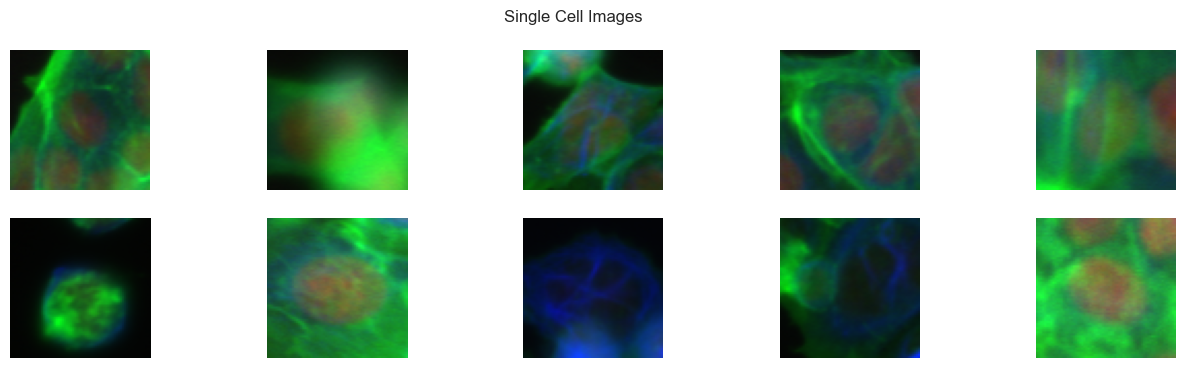

In [761]:
#plot a few MNIST examples
f, axarr = plt.subplots(2, 5, figsize=(16, 4))

# Load a batch of images into memory
images, labels = next(iter(training_loader))

for i, ax in enumerate(axarr.flat):
    img = images[i].view(3, 68, 68)
    img = img.permute((1, 2, 0)).numpy()
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.axis('off')
    
plt.suptitle('Single Cell Images')
plt.show()

### Variational autoencoder class

In [787]:
class VariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(VariationalAutoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)
        

        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoder = nn.Sequential(
            nn.Linear(in_features=self.observation_features, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            # A Gaussian is fully characterised by its mean \mu and variance \sigma**2
            nn.Linear(in_features=128, out_features=2*latent_features), # <- note the 2*latent_features
        )
        
        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=2*self.observation_features)
        )
        
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.encoder(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        #px_output = self.decoder(z)
        #px_output = px_output.view(-1, *self.input_shape) # reshape the output
        
        #return Bernoulli(logits=px_output, validate_args=False)
        
        px_output = self.decoder(z)
        mu, log_sigma = px_output.chunk(2, dim=-1)
        print(f"mu: {mu.shape}")
        print(f"log_sigma: {log_sigma.shape}")
        
        #mu = mu.view(-1, *self.input_shape)
        #log_sigma = log_sigma.view(-1, *self.input_shape)
        return ReparameterizedDiagonalGaussianWithSigmoid(mu, log_sigma) # Sample from the Normal distribution
        

    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # flatten the input
        x = x.view(x.size(0), -1)
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample() # qz.mu for test
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    
    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""
        
        # degine the prior p(z)
        pz = self.prior(batch_size=batch_size)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'z': z}


latent_features = 10
vae = VariationalAutoencoder(images[0].shape, latent_features)
loss_fn = nn.MSELoss(reduction='none')
print(vae)

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=13872, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=27744, bias=True)
  )
)


In [804]:
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta=1):
        super().__init__()
        self.beta = beta
        
    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:
        
        # forward pass through the model
        outputs = model(x)
        
        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
        
        
        # evaluate log probabilities
        #log_px = reduce(px.log_prob(x))
        
        log_px = - loss_fn(px.rsample(), x).sum(1)
        #log_px = - reduce(loss_fn(px.rsample(), x))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))
        
        # compute the ELBO with and without the beta parameter: 
        # `L^\beta = E_q [ log p(x|z) ] - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        kl = log_qz - log_pz
        elbo = log_px - kl # <- your code here
        beta_elbo = log_px - self.beta * kl # <- your code here
        
        # loss
        loss = - beta_elbo.mean()
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}
            
        return loss, diagnostics, outputs

In [805]:
vi_test = VariationalInference(beta=1)
loss, diagnostics, outputs = vi_test(vae, images)
print(f"{'loss':6} | mean = {loss:10.3f}, shape: {list(loss.shape)}")
for key, tensor in diagnostics.items():
    print(f"{key:6} | mean = {tensor.mean():10.3f}, shape: {list(tensor.shape)}")

mu: torch.Size([64, 13872])
log_sigma: torch.Size([64, 13872])
loss   | mean =   2076.485, shape: []
elbo   | mean =  -2076.485, shape: [64]
log_px | mean =  -2076.363, shape: [64]
kl     | mean =      0.122, shape: [64]


In [766]:
def evaluation(test_loader, name=None, model_best=None, epoch=None,
               device='cpu'):
    # EVALUATION
    if model_best is None:
        # load best performing model
        model_best = torch.load(name + '.model')

    model_best.eval()
    loss = 0.
    N = 0.
    for indx_batch, (test_batch, test_target) in enumerate(test_loader):
        test_batch = test_batch.to(device)
        
        #loss_t = model_best.forward(test_batch, reduction='sum')
        loss_t, diagnostics, outputs = vi(model_best, test_batch)
        loss = loss + loss_t.item()
        N = N + test_batch.shape[0]
    loss = loss / N

    if epoch is None:
        print(f'FINAL LOSS: nll={loss}')
    else:
        print(f'Epoch: {epoch}, val nll={loss}')

    return loss

def samples_real(name, test_loader):
    # REAL-------
    num_x = 4
    num_y = 4
    x = next(iter(test_loader))[0].detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.transpose(x[i].reshape((3, 68, 68)), (1, 2, 0))
        ax.imshow(plottable_image)
        ax.axis('off')

    plt.savefig(name + '_real_images.pdf', bbox_inches='tight')
    plt.close()
    

def samples_generated(name, data_loader, extra_name=''):
    x = next(iter(data_loader))[0].detach().numpy()

    # GENERATIONS-------
    model_best = torch.load(name + '.model')
    model_best.eval()

    num_x = 4
    num_y = 4
    
    px = model_best.sample_from_prior(batch_size=num_x * num_y)['px']
    x_samples = px.sample()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x_samples[i], (3, 68, 68)).permute(1, 2, 0)
        ax.imshow(plottable_image)
        ax.axis('off')

    plt.savefig(name + '_generated_images' + extra_name + '.pdf', bbox_inches='tight')
    plt.close()
    

def plot_curve(name, nll_val):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth='3')
    plt.xlabel('epochs')
    plt.ylabel('nll')
    plt.savefig(name + '_nll_val_curve.pdf', bbox_inches='tight')
    plt.close()

In [767]:
#import os
#from typing import *

#import matplotlib.pyplot as plt
#import numpy as np
#import seaborn as sns
#import torch
#from IPython.display import Image, display, clear_output
#from sklearn.manifold import TSNE
#from torch import Tensor
#from torch.distributions import Normal
from torchvision.utils import make_grid


def plot_samples(ax, x):
    x = x.to('cpu')
    nrow = int(np.sqrt(x.size(0)))
    x_grid = make_grid(x.view(-1, 3, 68, 68), nrow=nrow).permute(1, 2, 0)
    ax.imshow(x_grid)
    ax.axis('off')

def plot_interpolations(ax, vae):
    device = next(iter(vae.parameters())).device
    nrow = 10
    nsteps = 10
    prior_params = vae.prior_params.expand(2 * nrow, *vae.prior_params.shape[-1:])
    mu, log_sigma = prior_params.chunk(2, dim=-1)
    pz = Normal(mu, log_sigma.exp())
    z = pz.sample().view(nrow, 2, -1)
    t = torch.linspace(0, 1, 10, device=device)
    zs = t[None, :, None] * z[:, 0, None, :] + (1 - t[None, :, None]) * z[:, 1, None, :]
    px = vae.observation_model(zs.view(nrow * nsteps, -1))
    x = px.sample()
    x = x.to('cpu')
    x_grid = make_grid(x.view(-1, 3, 68, 68), nrow=nrow).permute(1, 2, 0)
    ax.imshow(x_grid)
    ax.axis('off')


def plot_grid(ax, vae):
    device = next(iter(vae.parameters())).device
    nrow = 10
    xv, yv = torch.meshgrid([torch.linspace(-3, 3, 10), torch.linspace(-3, 3, 10)])
    zs = torch.cat([xv[:, :, None], yv[:, :, None]], -1)
    zs = zs.to(device)
    px = vae.observation_model(zs.view(nrow * nrow, 2))
    x = px.sample()
    x = x.to('cpu')
    x_grid = make_grid(x.view(-1, 3, 68, 68), nrow=nrow).permute(1, 2, 0)
    ax.imshow(x_grid)
    ax.axis('off')


def plot_2d_latents(ax, qz, z, y):
    z = z.to('cpu')
    y = y.to('cpu')
    scale_factor = 2
    batch_size = z.shape[0]
    palette = sns.color_palette()
    colors = [palette[l] for l in y]

    # plot prior
    prior = plt.Circle((0, 0), scale_factor, color='gray', fill=True, alpha=0.1)
    ax.add_artist(prior)

    # plot data points
    mus, sigmas = qz.mu.to('cpu'), qz.sigma.to('cpu')
    mus = [mus[i].numpy().tolist() for i in range(batch_size)]
    sigmas = [sigmas[i].numpy().tolist() for i in range(batch_size)]

    posteriors = [
        plt.matplotlib.patches.Ellipse(mus[i], *(scale_factor * s for s in sigmas[i]), color=colors[i], fill=False,
                                       alpha=0.3) for i in range(batch_size)]
    for p in posteriors:
        ax.add_artist(p)

    ax.scatter(z[:, 0], z[:, 1], color=colors)

    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_aspect('equal', 'box')


def plot_latents(ax, z, y):
    z = z.to('cpu')
    palette = sns.color_palette()
    colors = [palette[l] for l in y]
    z = TSNE(n_components=2).fit_transform(z)
    ax.scatter(z[:, 0], z[:, 1], color=colors)


def make_vae_plots(vae, x, y, outputs, training_data, validation_data, 
                   tmp_img="tmp_vae_out.png", save_img="vae_out.png", figsize=(18, 18), save=False):
    
    fig, axes = plt.subplots(3, 3, figsize=figsize, squeeze=False)

    # plot the observation
    axes[0, 0].set_title(r'Observation $\mathbf{x}$')
    fig = plot_samples(axes[0, 0], x) 

    # plot the latent samples
    try:
        z = outputs['z']
        if z.shape[1] == 2:
            axes[0, 1].set_title(r'Latent Samples $\mathbf{z} \sim q_\phi(\mathbf{z} | \mathbf{x})$')
            qz = outputs['qz']
            plot_2d_latents(axes[0, 1], qz, z, y)
        else:
            axes[0, 1].set_title(r'Latent Samples $\mathbf{z} \sim q_\phi(\mathbf{z} | \mathbf{x})$ (t-SNE)')
            plot_latents(axes[0, 1], z, y)
    except Exception as e:
        print(f"Could not generate the plot of the latent sanples because of exception")
        print(e)

    # plot posterior samples
    axes[0, 2].set_title(
        r'Reconstruction $\mathbf{x} \sim p_\theta(\mathbf{x} | \mathbf{z}), \mathbf{z} \sim q_\phi(\mathbf{z} | \mathbf{x})$')
    px = outputs['px']
    x_sample = px.sample().to('cpu')
    plot_samples(axes[0, 2], x_sample)

    # plot ELBO
    ax = axes[1, 0]
    ax.set_title(r'ELBO: $\mathcal{L} ( \mathbf{x} )$')
    ax.plot(training_data['elbo'], label='Training')
    ax.plot(validation_data['elbo'], label='Validation')
    ax.legend()

    # plot KL
    ax = axes[1, 1]
    ax.set_title(r'$\mathcal{D}_{\operatorname{KL}}\left(q_\phi(\mathbf{z}|\mathbf{x})\ |\ p(\mathbf{z})\right)$')
    ax.plot(training_data['kl'], label='Training')
    ax.plot(validation_data['kl'], label='Validation')
    ax.legend()

    # plot NLL
    ax = axes[1, 2]
    ax.set_title(r'$\log p_\theta(\mathbf{x} | \mathbf{z})$')
    ax.plot(training_data['log_px'], label='Training')
    ax.plot(validation_data['log_px'], label='Validation')
    ax.legend()

    # plot prior samples
    axes[2, 0].set_title(r'Samples $\mathbf{x} \sim p_\theta(\mathbf{x} | \mathbf{z}), \mathbf{z} \sim p(\mathbf{z})$')
    px = vae.sample_from_prior(batch_size=x.size(0))['px']
    x_samples = px.sample()
    plot_samples(axes[2, 0], x_samples)

    # plot interpolations samples
    axes[2, 1].set_title(
        r'Latent Interpolations: $\mathbf{x} \sim p_\theta(\mathbf{x} | t \cdot \mathbf{z}_1 + (1-t) \cdot \mathbf{z}_2), \mathbf{z}_1, \mathbf{z}_2 \sim p(\mathbf{z}), t=0 \dots 1$')
    plot_interpolations(axes[2, 1], vae)

    # plot samples (sampling from a grid instead of the prior)
    if vae.latent_features == 2:
        axes[2, 2].set_title(
            r'Samples: $\mathbf{x} \sim p_\theta(\mathbf{x} | \mathbf{z}), \mathbf{z} \sim \operatorname{grid}(-3:3, -3:3)$')
        px = vae.sample_from_prior(batch_size=x.size(0))['px']
        x_samples = px.sample()
        plot_grid(axes[2, 2], vae)
        
    if save:
        plt.savefig(save_img)
        plt.close(fig)
    else:
        # display
        plt.tight_layout()
        plt.savefig(tmp_img)
        plt.close(fig)    
        display(Image(filename=tmp_img))
        clear_output(wait=True)

        os.remove(tmp_img)
    

In [770]:
name = 'vae'
result_dir = 'results/'

# define the models, evaluator and optimizer

# VAE
latent_features = 10
vae = VariationalAutoencoder(images[0].shape, latent_features)

# Evaluator: Variational Inference
beta = 0.01
vi = VariationalInference(beta=beta)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0

In [771]:
num_epochs = 30
nll_val = []
best_nll = -1000000.
patience = 0
max_patience = 20
name = 'vae'
result_dir = 'results/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

# move the model to the device
vae = vae.to(device)

# training..
while epoch < num_epochs:
    epoch += 1
    training_epoch_data = defaultdict(list)
    vae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for x, y in training_loader:
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)
        
        optimizer.zero_grad()
        print(loss)
        loss.backward()
        optimizer.step()
        
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]
            
    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]
        
    # Evaluate on a single batch, do not propagate gradients
    with torch.no_grad():
        vae.eval()
        
        # Just load a single batch from the validation loader
        x, y = next(iter(val_loader))
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss_val, diagnostics, outputs = vi(vae, x)
        nll_val.append(loss_val)  # save for plotting
        
        # gather data for the validation step
        for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]
    
    # Reproduce the figure from the begining of the notebook, plot the training curves and show latent samples
    make_vae_plots(vae, x, y, outputs, training_data, validation_data)

    if epoch == 1:
            print('saved!')
            torch.save(vae, result_dir + name + '_new.model')
            best_nll = loss_val
    else:
        if loss_val < best_nll:
            print('saved!')
            torch.save(vae, result_dir + name + '.model')
            best_nll = loss_val
            patience = 0

            samples_generated(result_dir + name, val_loader, extra_name="_epoch_" + str(epoch))
        else:
            patience = patience + 1
        
    if patience > max_patience:
        print("Max patience reached! Performing early stopping!")
        break
    

>> Using device: cpu
tensor(2139.8496, grad_fn=<NegBackward0>)
tensor(2048.7686, grad_fn=<NegBackward0>)
tensor(1824.9106, grad_fn=<NegBackward0>)


KeyboardInterrupt: 

In [752]:
make_vae_plots(vae, x, y, outputs, training_data, validation_data, save=True, save_img="vae_out_beta_0.005_normal_epochs_30.png")

Could not generate the plot of the latent sanples because of exception
list index out of range


In [753]:
test_loss = evaluation(name=result_dir + name, test_loader=test_loader)
f = open(result_dir + name + '_test_loss.txt', "w")
f.write(str(test_loss))
f.close()

samples_real(result_dir + name, test_loader)

plot_curve(result_dir + name, nll_val)

FINAL LOSS: nll=2.2541135486803556


In [772]:
print(torch.__version__)

1.12.1


In [775]:
!nvcc --version

zsh:1: command not found: nvcc
